<a href="https://colab.research.google.com/github/abdonasser-en/Human-action-recognition/blob/main/Human_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip IMU.zip

In [ ]:
import sys
import glob
import shutil
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
from plotly.graph_objs import Layout, YAxis, Scatter, Annotation, Annotations, Data, Figure, Marker, Font
import plotly.graph_objects as go
import plotly.express as px
import math
from scipy.signal import spectrogram
from pathlib import Path
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,LSTM
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kurtosis, entropy
from scipy import signal
from sklearn.model_selection import train_test_split
from scipy.signal import cwt


#**Les fonctions**

In [ ]:
def fill_Convert_dataFrame(path:str)->pd.DataFrame:
  # Load data from file at path using loadmat function
  data=loadmat(path)
  
  # Convert data to pandas DataFrame
  pd_data=pd.DataFrame(data['d_iner'])
  
  # Extract information from file name
  title_name=Path(path).stem
  title_lis=title_name.split('_')
  title_lis.pop()
  
  # Create new columns for Action, Subject, and Experience
  for i in title_lis:
    action_value=int(i[1:])
    if i[0]=='a':
      data_action=pd.Series([action_value]*data['d_iner'].shape[0],name="Action")
    elif i[0]=='s':
      data_subject=pd.Series([action_value]*data['d_iner'].shape[0],name="Subject")
    elif i[0]=='t':
      experience=pd.Series([action_value]*data['d_iner'].shape[0],name="Experience")

  # Concatenate new columns with original DataFrame
  serie_concat= pd.DataFrame({'Action':data_action, 'Subject':data_subject,'Experience':experience})
  pd_total=pd.concat([pd_data,serie_concat],axis=1)

  # Return resulting DataFrame
  return pd_total


In [ ]:
def global_data(folder_path:str):
  # Create empty list to store processed dataframes
  list_to_concat=[]
  list_pd_lenght=[]
  
  # Iterate through all files in folder
  for filename in glob.iglob(f'{folder_path}/*'):
    # Append processed dataframe for each file to list
    pd_frame=fill_Convert_dataFrame(filename)
    list_to_concat.append(pd_frame)
    list_pd_lenght.append(len(pd_frame))


  # Concatenate all dataframes in list along rows
  pd_final=pd.concat(list_to_concat,axis=0,ignore_index=True)
  
  # Return final concatenated dataframe
  return pd_final,list_pd_lenght


In [ ]:
def tracer_signal(path:str):
    data_sensor=fill_Convert_dataFrame(path)
    Fs = 50 
    time = np.linspace(0, len(data_sensor)/Fs, len(data_sensor))

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'les signaux inertiels pour l\'action{data_sensor.iloc[0,6]}')

    # accelerometre
    sns.lineplot(ax=axes[0], x=time, y=data_sensor.iloc[:,0],label="X")
    sns.lineplot(ax=axes[0], x=time, y=data_sensor.iloc[:,1],label="Y")
    sns.lineplot(ax=axes[0], x=time, y=data_sensor.iloc[:,2],label="Z")
    axes[0].set_title(f'l\'accéléromètre pour l\'action{data_sensor.iloc[0,6]}')
    axes[0].set_xlabel('Temps (s)')
    axes[0].set_ylabel('Accéléromètre m/s²')


    # gyrocope
    sns.lineplot(ax=axes[1], x=time, y=data_sensor.iloc[:,3],label="X")
    sns.lineplot(ax=axes[1], x=time, y=data_sensor.iloc[:,4],label="Y")
    sns.lineplot(ax=axes[1], x=time, y=data_sensor.iloc[:,5],label="Z")
    axes[1].set_title(f'le gyroscope  pour l\'action{data_sensor.iloc[0,6]}')
    axes[1].set_xlabel('Temps (s)')
    axes[1].set_ylabel('le gyroscope rad/s')

    plt.legend()
    plt.show()



In [ ]:
def train_test_split(data:pd.DataFrame):
  # Define the set of indexes for the training set
  set_train={1,3,5,7}
  # Define the set of indexes for the test set
  set_test={2,4,6,8}
  # Initialize empty lists for the training and test sets
  X_train=[]
  y_train=[]
  X_test=[]
  y_test=[]
  # Iterate over the rows of the input DataFrame
  for i in data.index:
    # Check if the index is in the training set
    if i[1] in set_train:
      # Append the row and the label to the training sets
      X_train.append(data.loc[(i[0], i[1]), :])
      y_train.append(i[0])
    # Check if the index is in the test set
    elif i[1] in set_test:
      # Append the row and the label to the test sets
      X_test.append(data.loc[(i[0], i[1]), :])
      y_test.append(i[0])

  # Convert the lists to DataFrames
  X_train=pd.DataFrame(X_train)
  X_test=pd.DataFrame(X_test)
  y_train=pd.DataFrame(y_train)
  y_test=pd.DataFrame(y_test)
  # Rename the columns of y_train and y_test
  y_train=y_train.rename(columns={0:'Action'})
  y_test=y_test.rename(columns={0:'Action'})

  return X_train, y_train,X_test,y_test

In [ ]:
def grouby_rename_colums(data:pd.DataFrame):
     # drop the column "Experience" and group the remaining data by columns "Action" and "Subject"
    data_grouby = data.drop(["Experience"],axis=1).groupby(['Action',"Subject"])
    
    #Calculate the following statistics for each group: mean, standard deviation, kurtosis, energy, welch mean and welch standard deviation
    data_grouby = data_grouby.agg([('mean', 'mean'), ('std', 'std'), ('kurtosis', kurtosis), ('energy', lambda x: np.mean(np.square(x)))])
    
    #Rename the columns to reflect the statistics calculated for each group
    table=[col[1]+'_'+str(col[0]) for i, col in enumerate(data_grouby.columns)]

    data_grouby.columns=table

    return data_grouby

In [ ]:
def normalisation(data: pd.DataFrame,type_norm):

  # Select the columns to be normalized
  col_train=data.columns
  cols_to_normalize =data.loc[:,list(col_train)]

  # Initialize StandardScaler
  scaler = type_norm

  # apply standard scaler to the columns selected
  cols_to_normalize  = scaler.fit_transform(data)

  # replace the column normalized in the DataFrame 
  data.loc[:, list(col_train)] = cols_to_normalize
  return data

In [ ]:
def fit_score_plot(model,X_train,y_train,X_test,y_test):
    # train the model on the input data
    model.fit(X_train, y_train)
    
    # make predictions on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # calculate evaluation metrics
    precision = precision_score(y_train,y_pred_train,average='macro')
    recall = recall_score(y_train,y_pred_train,average='macro')
    f_score = f1_score(y_train,y_pred_train,average='macro')
    score_train=accuracy_score(y_train,y_pred_train)
    score_test= accuracy_score(y_test, y_pred_test)
    
    # print out the model, score_test, score_train, precision, recall, f_score
    print(f'Model : {model}  score_test : {score_test}, score_train: {score_train},precision: {precision},recall: {recall},f_score: {f_score}')


In [ ]:
def cross_val(model,cv,X_train, y_train):
    # perform cross-validation on the given model using the provided training data and number of folds
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    # print the mean score along with the model
    print(f'Model : {model}  score : {scores.mean()}')


In [ ]:
def grid_search_model(model,params,cv,X_train, y_train):
  # perform a grid search to find the best parameters for the model
  grid_search = GridSearchCV(model, params, cv=cv)
  # fit the grid_search object to the training data
  grid_search.fit(X_train, y_train)
  # get the best parameters and best score
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  # print the model, the best parameters and the best score
  print(f'Model : {model}  best_params : {best_params} best_score : {best_score}')


## **Projet:**

In [ ]:
test= loadmat(r'/content/IMU/a11_s1_t1_inertial.mat')

In [ ]:
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Dec 28 15:44:24 2014',
 '__version__': '1.0',
 '__globals__': [],
 'd_iner': array([[ -0.970215,  -0.449463,  -0.133057,   4.458015,   3.664122,
          -4.458015],
        [ -0.976318,  -0.444824,  -0.149902,   3.572519,   7.267176,
          -9.19084 ],
        [ -0.99292 ,  -0.481445,  -0.175781,   8.641221,  12.519084,
         -15.603053],
        ...,
        [ -0.90625 ,  -0.291992,  -0.122803, -12.763359,  -6.259542,
          -5.465649],
        [ -0.90918 ,  -0.296631,  -0.141846, -16.977099,  -8.732824,
          -2.473282],
        [ -0.915771,  -0.291016,  -0.144531, -20.916031, -11.145038,
           0.885496]])}

In [ ]:
len(test['d_iner'])

181

In [ ]:
test['d_iner'].shape

(181, 6)

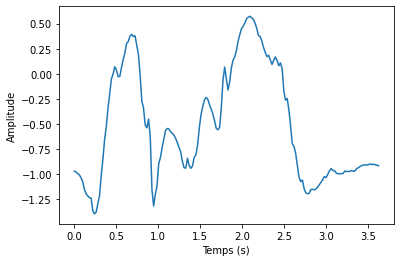

In [ ]:
# Create a time vector according to the sampling frequency and the length of the samples
Fs = 50 # sampling frequency
time = np.linspace(0, len(test['d_iner'])/Fs, len(test['d_iner']))

# Plot the data using a time graph
plt.plot(time, test['d_iner'][:,0])
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
from pathlib import Path

a=Path('/content/IMU/a10_s1_t1_inertial.mat').stem
a=a.split('_')
a.pop()

print(a)

series_exempe=pd.Series([int(a[0][1:])]*12, name="subjet")
series_exempe

['a10', 's1', 't1']


0     10
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
11    10
Name: subjet, dtype: int64

In [ ]:
# preprossing and convert data 
test=fill_Convert_dataFrame("/content/IMU/a10_s1_t1_inertial.mat")

In [ ]:
test.iloc[0,6]

10

In [ ]:
directory='/content/IMU'
# gather all the  data file and convert to data frame
data,list_pd_lenght=global_data(directory)

In [ ]:
len(list_pd_lenght)

861

In [ ]:
sum(list_pd_lenght)

155638

In [ ]:
data

0         1         2          3         4         5  Action  \
0      -0.990234 -0.176025 -0.122314 -28.274809  1.496183 -3.938931      21   
1      -0.986572 -0.156494 -0.116943 -26.564885  0.763359 -3.694656      21   
2      -0.978027 -0.142090 -0.107422 -23.450382 -0.427481 -3.480916      21   
3      -0.972900 -0.146484 -0.104980 -18.198473 -1.618321 -3.419847      21   
4      -0.976807 -0.140625 -0.103271 -14.290076 -2.687023 -2.656489      21   
...          ...       ...       ...        ...       ...       ...     ...   
155633 -0.964111 -0.327881  0.146240  -4.977099 -2.961832  3.572519      17   
155634 -0.966064 -0.331055  0.156006  -4.977099 -1.099237  3.969466      17   
155635 -0.951660 -0.321533  0.175049  -4.366412  0.274809  3.816794      17   
155636 -0.984619 -0.328857  0.179688  -2.931298  0.549618  3.541985      17   
155637 -0.968750 -0.327148  0.188477  -2.778626  1.618321  3.877863      17   

        Subject  Experience  
0             3           3  
1             3           3  
2             3           3  
3             3           3  
4             3           3  
...         ...         ...  
155633        8           4  
155634        8           4  
155635        8           4  
155636        8           4  
155637        8           4  

[155638 rows x 9 columns]

In [ ]:
data.head(1000)


0         1         2          3          4           5  Action  \
0   -0.990234 -0.176025 -0.122314 -28.274809   1.496183   -3.938931      21   
1   -0.986572 -0.156494 -0.116943 -26.564885   0.763359   -3.694656      21   
2   -0.978027 -0.142090 -0.107422 -23.450382  -0.427481   -3.480916      21   
3   -0.972900 -0.146484 -0.104980 -18.198473  -1.618321   -3.419847      21   
4   -0.976807 -0.140625 -0.103271 -14.290076  -2.687023   -2.656489      21   
..        ...       ...       ...        ...        ...         ...     ...   
995  1.425049  0.314697 -1.000977  75.328244  43.114504 -112.030534      13   
996  1.947754  0.430176 -0.788086  68.396947  57.129771  -78.931298      13   
997  1.871826  0.660400 -0.728027  33.251908  24.580153  -50.198473      13   
998  1.635010  0.840820 -1.009766  -8.183206 -13.435115  -39.083969      13   
999  1.500000  1.096924 -1.213623 -34.473282 -31.694656  -34.503817      13   

     Subject  Experience  
0          3           3  
1          3           3  
2          3           3  
3          3           3  
4          3           3  
..       ...         ...  
995        5           4  
996        5           4  
997        5           4  
998        5           4  
999        5           4  

[1000 rows x 9 columns]

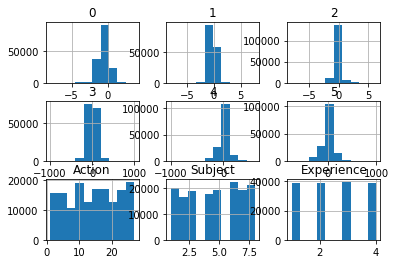

In [ ]:
data.hist()
plt.show()

In [ ]:
data.head()

0         1         2          3         4         5  Action  \
0 -0.990234 -0.176025 -0.122314 -28.274809  1.496183 -3.938931      21   
1 -0.986572 -0.156494 -0.116943 -26.564885  0.763359 -3.694656      21   
2 -0.978027 -0.142090 -0.107422 -23.450382 -0.427481 -3.480916      21   
3 -0.972900 -0.146484 -0.104980 -18.198473 -1.618321 -3.419847      21   
4 -0.976807 -0.140625 -0.103271 -14.290076 -2.687023 -2.656489      21   

   Subject  Experience  
0        3           3  
1        3           3  
2        3           3  
3        3           3  
4        3           3

In [ ]:
data.iloc[:,0]

0        -0.990234
1        -0.986572
2        -0.978027
3        -0.972900
4        -0.976807
            ...   
155633   -0.964111
155634   -0.966064
155635   -0.951660
155636   -0.984619
155637   -0.968750
Name: 0, Length: 155638, dtype: float64

In [ ]:
import plotly.express as px

fig = px.scatter_3d(data, x=0,y=1,z=2)

fig.show()

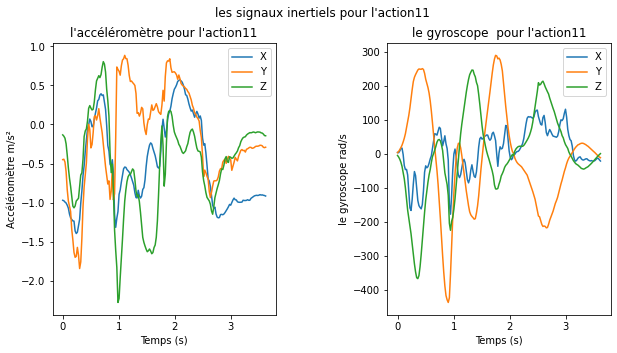

In [ ]:
# plot signal
tracer_signal("/content/IMU/a11_s1_t1_inertial.mat")

In [ ]:
#extraction 
data=grouby_rename_colums(data)

In [ ]:
data

mean_0     std_0  kurtosis_0  energy_0    mean_1     std_1  \
Action Subject                                                                 
1      1       -0.548118  0.436651   -1.544015  0.490798 -0.101052  0.502308   
       2       -0.529399  0.559647   -1.257551  0.592944 -0.184759  0.694947   
       3       -0.609866  0.506191   -1.468982  0.627697 -0.229931  0.602371   
       4       -0.868558  0.465813   -0.656481  0.971007 -0.190084  0.738810   
       5       -0.665988  0.425977   -1.372143  0.624746 -0.273509  0.425144   
...                  ...       ...         ...       ...       ...       ...   
27     4       -0.881691  0.128513   -0.500290  0.793870 -0.354902  0.310863   
       5       -0.888660  0.170514    0.827411  0.818763 -0.309177  0.315316   
       6       -0.878852  0.201964    7.800239  0.813135 -0.186103  0.417261   
       7       -0.863865  0.122525   -0.707374  0.761254 -0.222331  0.355941   
       8       -0.808204  0.176548    3.684231  0.684323 -0.267566  0.385526   

                kurtosis_1  energy_1    mean_2     std_2  ...  kurtosis_3  \
Action Subject                                            ...               
1      1         -0.166446  0.262129 -0.538813  0.262218  ...    0.045429   
       2         -0.428858  0.516280 -0.141455  0.367902  ...    0.363775   
       3          0.050685  0.415057 -0.388711  0.276910  ...    1.925539   
       4         -0.732314  0.581048 -0.108488  0.329882  ...   -0.153152   
       5         -0.330713  0.255306 -0.259910  0.446086  ...    0.386510   
...                    ...       ...       ...       ...  ...         ...   
27     4         -1.014806  0.222447  0.274263  0.078804  ...    0.275824   
       5         -0.460405  0.194918  0.224528  0.123562  ...    7.111592   
       6         -0.504566  0.208594  0.187693  0.155263  ...    3.227992   
       7         -1.447082  0.175947  0.422624  0.071023  ...    1.888957   
       8         -1.156876  0.220031  0.350727  0.262575  ...    2.621559   

                    energy_3     mean_4      std_4  kurtosis_4     energy_4  \
Action Subject                                                                
1      1         5478.543801   1.687059  89.697976    0.467713  8035.942393   
       2        19932.739947   8.680232  85.970330    1.416727  7453.884765   
       3         7247.595899 -10.840419  87.310150    0.582903  7726.666290   
       4        10373.447224  -0.876336  85.959737    0.170284  7377.320432   
       5        12091.528188   5.372490  51.080609    2.745946  2634.498241   
...                      ...        ...        ...         ...          ...   
27     4          437.359965   1.136389   8.282671    4.831138    69.791475   
       5          323.758945   0.574817   9.642404    5.361062    93.216093   
       6          327.133161   0.613512  12.167555   49.427104   148.300107   
       7          237.790933   1.245742   8.739154    3.485164    77.817569   
       8          510.821721   1.022019  24.086540    1.268878   580.461186   

                   mean_5       std_5  kurtosis_5      energy_5  
Action Subject                                                   
1      1       -27.291718   80.112873   -0.298735   7152.834803  
       2       -36.454237  113.826342   -0.275179  14263.681152  
       3       -24.566167  140.046230   -0.310233  20180.653175  
       4        -9.732074  181.963326   -0.284177  33149.245421  
       5       -24.336004   64.048853    0.010451   4688.846137  
...                   ...         ...         ...           ...  
27     4        -0.845058   47.927252   -0.003602   2294.302111  
       5        -0.719336   40.567265    1.175897   1644.622668  
       6        -0.523490   42.444240    0.694935   1800.258265  
       7        -0.475017   48.765592    0.918977   2374.973297  
       8        -0.331370   38.637103    0.254443   1491.019170  

[216 rows x 24 columns]

In [ ]:
data.index

MultiIndex([( 1, 1),
            ( 1, 2),
            ( 1, 3),
            ( 1, 4),
            ( 1, 5),
            ( 1, 6),
            ( 1, 7),
            ( 1, 8),
            ( 2, 1),
            ( 2, 2),
            ...
            (26, 7),
            (26, 8),
            (27, 1),
            (27, 2),
            (27, 3),
            (27, 4),
            (27, 5),
            (27, 6),
            (27, 7),
            (27, 8)],
           names=['Action', 'Subject'], length=216)

In [ ]:
data.loc[(1, 2), :]

mean_0           -0.529399
std_0             0.559647
kurtosis_0       -1.257551
energy_0          0.592944
mean_1           -0.184759
std_1             0.694947
kurtosis_1       -0.428858
energy_1          0.516280
mean_2           -0.141455
std_2             0.367902
kurtosis_2       -1.160549
energy_2          0.155135
mean_3           33.826546
std_3           137.185918
kurtosis_3        0.363775
energy_3      19932.739947
mean_4            8.680232
std_4            85.970330
kurtosis_4        1.416727
energy_4       7453.884765
mean_5          -36.454237
std_5           113.826342
kurtosis_5       -0.275179
energy_5      14263.681152
Name: (1, 2), dtype: float64

In [ ]:
# split the dataset
X_train, y_train,X_test,y_test=train_test_split(data)

In [ ]:
X_train

mean_0     std_0  kurtosis_0  energy_0    mean_1     std_1  \
1  1 -0.548118  0.436651   -1.544015  0.490798 -0.101052  0.502308   
   3 -0.609866  0.506191   -1.468982  0.627697 -0.229931  0.602371   
   5 -0.665988  0.425977   -1.372143  0.624746 -0.273509  0.425144   
   7 -0.718784  0.459935   -1.067535  0.727835 -0.408144  0.415945   
2  1 -0.535244  0.439866   -1.530116  0.479645 -0.024691  0.471052   
...        ...       ...         ...       ...       ...       ...   
26 7 -0.959539  0.129579    3.291054  0.937485  0.006160  0.163852   
27 1 -0.896252  0.144714    1.205257  0.824188 -0.171813  0.400297   
   3 -0.881570  0.166168    0.924499  0.804749 -0.167274  0.402287   
   5 -0.888660  0.170514    0.827411  0.818763 -0.309177  0.315316   
   7 -0.863865  0.122525   -0.707374  0.761254 -0.222331  0.355941   

      kurtosis_1  energy_1    mean_2     std_2  ...  kurtosis_3      energy_3  \
1  1   -0.166446  0.262129 -0.538813  0.262218  ...    0.045429   5478.543801   
   3    0.050685  0.415057 -0.388711  0.276910  ...    1.925539   7247.595899   
   5   -0.330713  0.255306 -0.259910  0.446086  ...    0.386510  12091.528188   
   7   -0.274527  0.339301 -0.210681  0.432745  ...    1.154977  12767.263778   
2  1    0.705558  0.222128 -0.596001  0.293198  ...    0.215634   7360.790049   
...          ...       ...       ...       ...  ...         ...           ...   
26 7    2.189614  0.026854  0.425486  0.078588  ...    2.471720    633.830689   
27 1   -0.605374  0.189591  0.257286  0.086730  ...    6.899912    391.537784   
   3    0.380583  0.189643  0.350363  0.044878  ...    1.405550    733.741146   
   5   -0.460405  0.194918  0.224528  0.123562  ...    7.111592    323.758945   
   7   -1.447082  0.175947  0.422624  0.071023  ...    1.888957    237.790933   

         mean_4       std_4  kurtosis_4      energy_4     mean_5       std_5  \
1  1   1.687059   89.697976    0.467713   8035.942393 -27.291718   80.112873   
   3 -10.840419   87.310150    0.582903   7726.666290 -24.566167  140.046230   
   5   5.372490   51.080609    2.745946   2634.498241 -24.336004   64.048853   
   7 -23.862647   92.197987    0.783673   9055.632243 -21.511655  123.253506   
2  1 -18.833148  107.041845   -0.164861  11793.451405 -16.506758  110.177710   
...         ...         ...         ...           ...        ...         ...   
26 7   1.063058    8.907845    0.579980     80.385777  -0.412539   24.699822   
27 1   1.047087    9.167167    5.009278     85.045990  -0.473822   46.676583   
   3   1.506709   11.418932    8.524913    132.523013  -0.531858   51.543821   
   5   0.574817    9.642404    5.361062     93.216093  -0.719336   40.567265   
   7   1.245742    8.739154    3.485164     77.817569  -0.475017   48.765592   

      kurtosis_5      energy_5  
1  1   -0.298735   7152.834803  
   3   -0.310233  20180.653175  
   5    0.010451   4688.846137  
   7   -0.352514  15628.689142  
2  1    0.242943  12391.267253  
...          ...           ...  
26 7    4.459204    609.528546  
27 1    0.440088   2176.663139  
   3    0.768883   2654.213006  
   5    1.175897   1644.622668  
   7    0.918977   2374.973297  

[108 rows x 24 columns]

In [ ]:
y_train.shape

(108, 1)

In [ ]:
y_train

Action
0         1
1         1
2         1
3         1
4         2
..      ...
103      26
104      27
105      27
106      27
107      27

[108 rows x 1 columns]

In [ ]:
y_test

Action
0         1
1         1
2         1
3         1
4         2
..      ...
103      26
104      27
105      27
106      27
107      27

[108 rows x 1 columns]

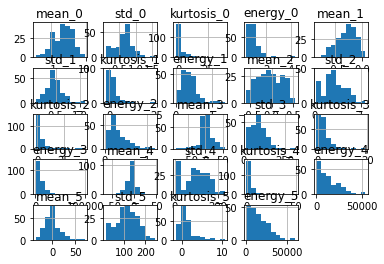

In [ ]:
data.hist()
plt.show()

In [ ]:
# normalisation de Xtrain et Xtest
X_train_ss=normalisation(X_train,StandardScaler())
X_test_ss=normalisation(X_test,StandardScaler())

In [ ]:
y_train.nunique()

Action    27
dtype: int64

# **Logisitic Regression**

In [ ]:
# Logisitic
log=LogisticRegression(C=0.5,solver='saga')

In [ ]:
fit_score_plot(log,X_train_ss,y_train,X_test_ss,y_test)

Model : LogisticRegression(C=0.5, solver='saga')  score_test : 0.75, score_train: 0.9537037037037037,precision: 0.9574074074074075,recall: 0.9537037037037037,f_score: 0.9534097589653145


In [ ]:
cross_val(log,4,X_train_ss,y_train)

Model : LogisticRegression(C=0.5, solver='saga')  score : 0.6388888888888888


In [ ]:
param_grid = {'C': [0.1, 0.5, 10], 'penalty': ['elasticnet', 'l1', 'l2', None]}
grid_search_model(log,param_grid,4,X_train_ss,y_train)


Model : LogisticRegression(C=0.5, solver='saga')  best_params : {'C': 0.1, 'penalty': 'l2'} best_score : 0.7037037037037037


# **RandomForestClassifier**

In [ ]:
rcl=RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=100)

In [ ]:
fit_score_plot(rcl,X_train_ss,y_train,X_test_ss,y_test)

Model : RandomForestClassifier(max_depth=100)  score_test : 0.7407407407407407, score_train: 1.0,precision: 1.0,recall: 1.0,f_score: 1.0


In [ ]:
cross_val(log,4,X_train_ss,y_train)

Model : LogisticRegression(C=0.5, solver='saga')  score : 0.6388888888888888


In [ ]:
param_grid = {'n_estimators': [10, 25,50, 75,100], 'criterion': ["gini", "entropy", "log_loss"],'max_depth':[50,100,25,60]}
grid_search_model(rcl,param_grid,4,X_train_ss,y_train)

Model : RandomForestClassifier(max_depth=100)  best_params : {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100} best_score : 0.6574074074074074


# **Kneighborsclassifier**

In [ ]:
kn=KNeighborsClassifier(n_neighbors=6,weights='distance',algorithm='auto', leaf_size=10)

In [ ]:
fit_score_plot(kn,X_train_ss,y_train,X_test_ss,y_test)

Model : KNeighborsClassifier(leaf_size=10, n_neighbors=6, weights='distance')  score_test : 0.6666666666666666, score_train: 1.0,precision: 1.0,recall: 1.0,f_score: 1.0


In [ ]:
cross_val(kn,4,X_train_ss,y_train)

Model : KNeighborsClassifier(leaf_size=10, n_neighbors=6, weights='distance')  score : 0.6203703703703703


In [ ]:
param_grid = {'n_neighbors': [2, 3, 6, 7, 9, 5], 'weights': ["uniform", "distance"],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'leaf_size':[10,20,30,50,40]}
grid_search_model(kn,param_grid,4,X_train_ss,y_train)

Model : KNeighborsClassifier(leaf_size=10, n_neighbors=6, weights='distance')  best_params : {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'weights': 'distance'} best_score : 0.6203703703703703


# **SVM**

In [ ]:
svm= SVC(C=1,kernel='linear',degree=1,gamma=0.1)

In [ ]:
fit_score_plot(svm,X_train_ss,y_train,X_test_ss,y_test)

Model : SVC(C=1, degree=1, gamma=0.1, kernel='linear')  score_test : 0.7685185185185185, score_train: 1.0,precision: 1.0,recall: 1.0,f_score: 1.0


In [ ]:
cross_val(svm,4,X_train_ss,y_train)

Model : SVC(C=1, degree=1, gamma=0.1, kernel='linear')  score : 0.6203703703703705


In [ ]:
param_grid = {'C': [0.1, 0.5,5,8, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4,5,6],'gamma':[0.1,0.3,0.5,0.2,1]}
grid_search_model(svm,param_grid,4,X_train_ss,y_train)

Model : SVC(C=1, degree=1, gamma=0.1, kernel='linear')  best_params : {'C': 0.1, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'} best_score : 0.6574074074074074


# **Reseau de Neurones**

In [ ]:
X_train_ss=normalisation(X_train,StandardScaler())
X_test_ss=normalisation(X_test,StandardScaler())

In [ ]:
X_train_tran=tf.convert_to_tensor(X_train_ss)

X_train_tran

<tf.Tensor: shape=(108, 36), dtype=float64, numpy=
array([[ 0.26365798, -0.74134208, -0.6265172 , ..., -0.6990039 ,
        -0.62632052, -0.31874409],
       [ 0.05179278, -0.49604811, -0.61103748, ...,  0.6525146 ,
         0.21445742,  1.09817699],
       [-0.14076976, -0.77899201, -0.59105883, ..., -0.95462047,
        -0.92489293, -0.92550027],
       ...,
       [-0.88046204, -1.69544409, -0.11724507, ..., -1.16569529,
        -1.09228173, -1.04198502],
       [-0.90478568, -1.68011207, -0.13727508, ..., -1.27043117,
        -1.20611267, -1.13868169],
       [-0.81971258, -1.84938831, -0.45391217, ..., -1.19466388,
        -1.10163982, -1.06376673]])>

In [ ]:
X_test_tran=tf.convert_to_tensor(X_test_ss)

X_test_tran

<tf.Tensor: shape=(108, 36), dtype=float64, numpy=
array([[ 0.58071423, -0.30538753, -0.54264337, ..., -0.23695596,
        -0.2136263 ,  0.13692175],
       [-0.78507231, -0.63962703, -0.4273193 , ...,  1.22242138,
         1.35451069,  2.01856527],
       [-0.74710947, -0.97243874, -0.41919951, ..., -0.32194574,
        -0.25873921,  0.0650142 ],
       ...,
       [-0.83795883, -1.84109081, -0.39735165, ..., -1.16188678,
        -1.13356328, -1.09670698],
       [-0.82652414, -1.57945822,  1.19522632, ..., -1.2000639 ,
        -1.19261955, -1.13939324],
       [-0.54202904, -1.66999052,  0.40550986, ..., -1.22396027,
        -1.22039672, -1.16273041]])>

In [ ]:

# créer un objet OneHotEncoder
encoder = OneHotEncoder()
# Transformer les données en utilisant l'encoder
y_encoded_train = encoder.fit_transform(y_train).toarray()
print(y_encoded_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
y_encoded_test = encoder.fit_transform(y_test).toarray()
print(y_encoded_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:

num_classes=27
# Create a sequential model
model = Sequential()

# Add a fully connected layer
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
# Add an output layer
model.add(Dense(num_classes,input_shape=(27,) ,activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_history=model.fit(X_train_tran, y_encoded_train, epochs=100, batch_size=32,validation_data=(X_test_tran, y_encoded_test),shuffle=True)


Epoch 1/100
4/4 [==============================] - 2s 80ms/step - loss: 3.2991 - accuracy: 0.0833 - val_loss: 3.1639 - val_accuracy: 0.1389
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 3.0597 - accuracy: 0.2315 - val_loss: 3.0263 - val_accuracy: 0.1852
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 2.8736 - accuracy: 0.3333 - val_loss: 2.8885 - val_accuracy: 0.2130
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 2.6886 - accuracy: 0.3611 - val_loss: 2.7467 - val_accuracy: 0.2315
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 2.4874 - accuracy: 0.3796 - val_loss: 2.5913 - val_accuracy: 0.2778
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 2.2878 - accuracy: 0.4444 - val_loss: 2.4377 - val_accuracy: 0.2685
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 2.0784 - accuracy: 0.5093 - val_loss: 2.2773 - val_accuracy: 0.3333
Epoch 8/100
4/4 [===

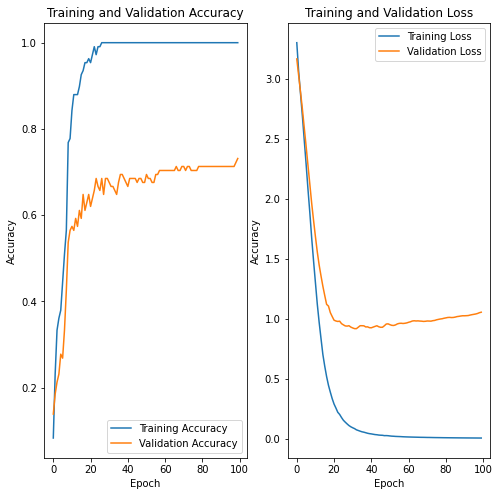

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

val_test=model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_test, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

4/4 [==============================] - 0s 3ms/step


Text(69.0, 0.5, 'Réalité')

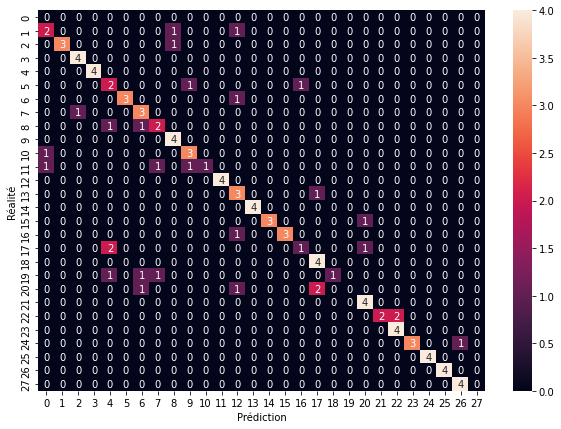

In [ ]:
# Stocker les prédictions de validation dans une variable
y_pred_valid = model.predict(X_test_tran)
# Transformer les prédictions en étiquettes
y_pred_valid_labels = [np.argmax(i) for i in y_pred_valid]
# Créer la matrice de confusion
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_valid_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')


# **Optimisation**

In [ ]:
directory='/content/IMU'
data,list_pd_lenght=global_data(directory)

In [ ]:
data

0         1         2          3         4         5  Action  \
0      -0.990234 -0.176025 -0.122314 -28.274809  1.496183 -3.938931      21   
1      -0.986572 -0.156494 -0.116943 -26.564885  0.763359 -3.694656      21   
2      -0.978027 -0.142090 -0.107422 -23.450382 -0.427481 -3.480916      21   
3      -0.972900 -0.146484 -0.104980 -18.198473 -1.618321 -3.419847      21   
4      -0.976807 -0.140625 -0.103271 -14.290076 -2.687023 -2.656489      21   
...          ...       ...       ...        ...       ...       ...     ...   
155633 -0.964111 -0.327881  0.146240  -4.977099 -2.961832  3.572519      17   
155634 -0.966064 -0.331055  0.156006  -4.977099 -1.099237  3.969466      17   
155635 -0.951660 -0.321533  0.175049  -4.366412  0.274809  3.816794      17   
155636 -0.984619 -0.328857  0.179688  -2.931298  0.549618  3.541985      17   
155637 -0.968750 -0.327148  0.188477  -2.778626  1.618321  3.877863      17   

        Subject  Experience  
0             3           3  
1             3           3  
2             3           3  
3             3           3  
4             3           3  
...         ...         ...  
155633        8           4  
155634        8           4  
155635        8           4  
155636        8           4  
155637        8           4  

[155638 rows x 9 columns]

In [ ]:
fs=50  # fs is the sampling frequency of the data

def grouby_rename_colums(data:pd.DataFrame):
    #Create an array of widths from 1 to 30
    widths = np.arange(1,31)

    # drop the column "Experience" and group the remaining data by columns "Action" and "Subject"
    data_grouby = data.drop(["Experience"],axis=1).groupby(['Action',"Subject"])
    
    #Calculate the following statistics for each group: mean, standard deviation, kurtosis, energy, welch mean and welch standard deviation
    data_grouby = data_grouby.agg([('mean', 'mean'), ('std', 'std'), ('kurtosis', kurtosis), ('energy', lambda x: np.mean(np.square(x))), ('welch_mean', lambda x: np.mean(signal.welch(x, fs)[1])), ('welch_std', lambda x: np.std(signal.welch(x, fs)[1]))])
    
    #Rename the columns to reflect the statistics calculated for each group
    table=[col[1]+'_'+str(col[0]) for i, col in enumerate(data_grouby.columns)]
    data_grouby.columns=table



    return data_grouby

In [ ]:
data=grouby_rename_colums(data)

In [ ]:
data

mean_0     std_0  kurtosis_0  energy_0  welch_mean_0  \
Action Subject                                                           
1      1       -0.548118  0.436651   -1.544015  0.490798      0.008835   
       2       -0.529399  0.559647   -1.257551  0.592944      0.012231   
       3       -0.609866  0.506191   -1.468982  0.627697      0.008344   
       4       -0.868558  0.465813   -0.656481  0.971007      0.008089   
       5       -0.665988  0.425977   -1.372143  0.624746      0.008370   
...                  ...       ...         ...       ...           ...   
27     4       -0.881691  0.128513   -0.500290  0.793870      0.000748   
       5       -0.888660  0.170514    0.827411  0.818763      0.001384   
       6       -0.878852  0.201964    7.800239  0.813135      0.001662   
       7       -0.863865  0.122525   -0.707374  0.761254      0.000674   
       8       -0.808204  0.176548    3.684231  0.684323      0.001529   

                welch_std_0    mean_1     std_1  kurtosis_1  energy_1  ...  \
Action Subject                                                         ...   
1      1           0.056610 -0.101052  0.502308   -0.166446  0.262129  ...   
       2           0.071667 -0.184759  0.694947   -0.428858  0.516280  ...   
       3           0.054741 -0.229931  0.602371    0.050685  0.415057  ...   
       4           0.036075 -0.190084  0.738810   -0.732314  0.581048  ...   
       5           0.048581 -0.273509  0.425144   -0.330713  0.255306  ...   
...                     ...       ...       ...         ...       ...  ...   
27     4           0.004137 -0.354902  0.310863   -1.014806  0.222447  ...   
       5           0.008079 -0.309177  0.315316   -0.460405  0.194918  ...   
       6           0.009057 -0.186103  0.417261   -0.504566  0.208594  ...   
       7           0.003720 -0.222331  0.355941   -1.447082  0.175947  ...   
       8           0.008964 -0.267566  0.385526   -1.156876  0.220031  ...   

                kurtosis_4     energy_4  welch_mean_4  welch_std_4     mean_5  \
Action Subject                                                                  
1      1          0.467713  8035.942393    325.576536  1860.571607 -27.291718   
       2          1.416727  7453.884765    257.092497  1271.788711 -36.454237   
       3          0.582903  7726.666290    299.042924  1749.627526 -24.566167   
       4          0.170284  7377.320432    306.597931  1717.106247  -9.732074   
       5          2.745946  2634.498241    120.861189   538.924904 -24.336004   
...                    ...          ...           ...          ...        ...   
27     4          4.831138    69.791475      2.199818     5.838156  -0.845058   
       5          5.361062    93.216093      4.103385    16.342646  -0.719336   
       6         49.427104   148.300107      5.862323    19.454846  -0.523490   
       7          3.485164    77.817569      3.725417    11.246053  -0.475017   
       8          1.268878   580.461186     24.298122   140.043861  -0.331370   

                     std_5  kurtosis_5      energy_5  welch_mean_5  \
Action Subject                                                       
1      1         80.112873   -0.298735   7152.834803    303.738999   
       2        113.826342   -0.275179  14263.681152    587.060288   
       3        140.046230   -0.310233  20180.653175    642.028684   
       4        181.963326   -0.284177  33149.245421   1403.999610   
       5         64.048853    0.010451   4688.846137    183.607437   
...                    ...         ...           ...           ...   
27     4         47.927252   -0.003602   2294.302111    107.808349   
       5         40.567265    1.175897   1644.622668     70.457780   
       6         42.444240    0.694935   1800.258265     77.042298   
       7         48.765592    0.918977   2374.973297    112.492764   
       8         38.637103    0.254443   1491.019170     62.571453   

                welch_std_5  
Action Subject               
1      1       

In [ ]:
X_train, y_train,X_test,y_test=train_test_split(data)

In [ ]:
X_train

mean_0     std_0  kurtosis_0  energy_0  welch_mean_0  welch_std_0  \
1  1 -0.548118  0.436651   -1.544015  0.490798      0.008835     0.056610   
   3 -0.609866  0.506191   -1.468982  0.627697      0.008344     0.054741   
   5 -0.665988  0.425977   -1.372143  0.624746      0.008370     0.048581   
   7 -0.718784  0.459935   -1.067535  0.727835      0.007997     0.043183   
2  1 -0.535244  0.439866   -1.530116  0.479645      0.007981     0.042422   
...        ...       ...         ...       ...           ...          ...   
26 7 -0.959539  0.129579    3.291054  0.937485      0.000525     0.001607   
27 1 -0.896252  0.144714    1.205257  0.824188      0.000829     0.005162   
   3 -0.881570  0.166168    0.924499  0.804749      0.001145     0.006126   
   5 -0.888660  0.170514    0.827411  0.818763      0.001384     0.008079   
   7 -0.863865  0.122525   -0.707374  0.761254      0.000674     0.003720   

        mean_1     std_1  kurtosis_1  energy_1  ...  kurtosis_4      energy_4  \
1  1 -0.101052  0.502308   -0.166446  0.262129  ...    0.467713   8035.942393   
   3 -0.229931  0.602371    0.050685  0.415057  ...    0.582903   7726.666290   
   5 -0.273509  0.425144   -0.330713  0.255306  ...    2.745946   2634.498241   
   7 -0.408144  0.415945   -0.274527  0.339301  ...    0.783673   9055.632243   
2  1 -0.024691  0.471052    0.705558  0.222128  ...   -0.164861  11793.451405   
...        ...       ...         ...       ...  ...         ...           ...   
26 7  0.006160  0.163852    2.189614  0.026854  ...    0.579980     80.385777   
27 1 -0.171813  0.400297   -0.605374  0.189591  ...    5.009278     85.045990   
   3 -0.167274  0.402287    0.380583  0.189643  ...    8.524913    132.523013   
   5 -0.309177  0.315316   -0.460405  0.194918  ...    5.361062     93.216093   
   7 -0.222331  0.355941   -1.447082  0.175947  ...    3.485164     77.817569   

      welch_mean_4  welch_std_4     mean_5       std_5  kurtosis_5  \
1  1    325.576536  1860.571607 -27.291718   80.112873   -0.298735   
   3    299.042924  1749.627526 -24.566167  140.046230   -0.310233   
   5    120.861189   538.924904 -24.336004   64.048853    0.010451   
   7    248.811344  1036.189708 -21.511655  123.253506   -0.352514   
2  1    391.860088  1662.725122 -16.506758  110.177710    0.242943   
...            ...          ...        ...         ...         ...   
26 7      3.284532     8.269809  -0.412539   24.699822    4.459204   
27 1      3.474940    10.177466  -0.473822   46.676583    0.440088   
   3      5.645101    15.542469  -0.531858   51.543821    0.768883   
   5      4.103385    16.342646  -0.719336   40.567265    1.175897   
   7      3.725417    11.246053  -0.475017   48.765592    0.918977   

          energy_5  welch_mean_5  welch_std_5  
1  1   7152.834803    303.738999  1763.050677  
   3  20180.653175    642.028684  4049.937363  
   5   4688.846137    183.607437   783.756450  
   7  15628.689142    571.381767  3171.635891  
2  1  12391.267253    388.817368  2095.111670  
...            ...           ...          ...  
26 7    609.528546     22.510913    75.652328  
27 1   2176.663139     94.697037   527.223020  
   3   2654.213006    116.258022   595.752030  
   5   1644.622668     70.457780   439.685251  
   7   2374.973297    112.492764   560.596728  

[108 rows x 36 columns]

In [ ]:
X_train_nor=normalisation(X_train,StandardScaler())

In [ ]:
X_train

mean_0     std_0  kurtosis_0  energy_0  welch_mean_0  welch_std_0  \
1  1  0.263658 -0.741342   -0.626517 -0.789433     -0.732406    -0.536890   
   3  0.051793 -0.496048   -0.611037 -0.565563     -0.763238    -0.563157   
   5 -0.140770 -0.778992   -0.591059 -0.570388     -0.761606    -0.649723   
   7 -0.321921 -0.659211   -0.528216 -0.401808     -0.784943    -0.725591   
2  1  0.307828 -0.730000   -0.623650 -0.807671     -0.785966    -0.736283   
...        ...       ...         ...       ...           ...          ...   
26 7 -1.147981 -1.824505    0.370992 -0.058971     -1.253426    -1.309882   
27 1 -0.930837 -1.771118   -0.059323 -0.244244     -1.234375    -1.259934   
   3 -0.880462 -1.695444   -0.117245 -0.276033     -1.214558    -1.246386   
   5 -0.904786 -1.680112   -0.137275 -0.253116     -1.199579    -1.218930   
   7 -0.819713 -1.849388   -0.453912 -0.347159     -1.244093    -1.280190   

        mean_1     std_1  kurtosis_1  energy_1  ...  kurtosis_4  energy_4  \
1  1  0.931716  0.219799   -0.724507 -0.390140  ...   -0.733305 -0.491394   
   3  0.182285  0.829061   -0.654489  0.358622  ...   -0.691174 -0.516826   
   5 -0.071123 -0.250038   -0.777478 -0.423548  ...    0.099965 -0.935557   
   7 -0.854027 -0.306052   -0.759360 -0.012291  ...   -0.617742 -0.407545   
2  1  1.375755  0.029486   -0.443312 -0.585992  ...   -0.964671 -0.182412   
...        ...       ...         ...       ...  ...         ...       ...   
26 7  1.555157 -1.841000    0.035251 -1.542094  ...   -0.692243 -1.145583   
27 1  0.520238 -0.401330   -0.866048 -0.745301  ...    0.927786 -1.145200   
   3  0.546636 -0.389211   -0.548107 -0.745046  ...    2.213640 -1.141296   
   5 -0.278532 -0.918764   -0.819300 -0.719220  ...    1.056452 -1.144528   
   7  0.226479 -0.671403   -1.137473 -0.812102  ...    0.370336 -1.145794   

      welch_mean_4  welch_std_4    mean_5     std_5  kurtosis_5  energy_5  \
1  1     -0.463303    -0.174951 -1.742439 -0.633228   -0.908782 -0.699004   
   3     -0.518980    -0.231585 -1.567357  0.718864   -0.914958  0.652515   
   5     -0.892869    -0.849617 -1.552572 -0.995630   -0.742729 -0.954620   
   7     -0.624384    -0.595777 -1.371142  0.340021   -0.937665  0.180289   
2  1     -0.324217    -0.275947 -1.049640  0.045032   -0.617866 -0.155564   
...            ...          ...       ...       ...         ...       ...   
26 7     -1.139586    -1.120503 -0.015787 -1.883341    1.646543 -1.377813   
27 1     -1.139186    -1.119529 -0.019724 -1.387547   -0.511986 -1.215237   
   3     -1.134633    -1.116790 -0.023452 -1.277743   -0.335402 -1.165695   
   5     -1.137868    -1.116382 -0.035495 -1.525373   -0.116808 -1.270431   
   7     -1.138661    -1.118984 -0.019801 -1.340419   -0.254791 -1.194664   

      welch_mean_5  welch_std_5  
1  1     -0.626321    -0.318744  
   3      0.214457     1.098177  
   5     -0.924893    -0.925500  
   7      0.038873     0.553994  
2  1     -0.414869    -0.113004  
...            ...          ...  
26 7     -1.325279    -1.364231  
27 1     -1.145869    -1.084445  
   3     -1.092282    -1.041985  
   5     -1.206113    -1.138682  
   7     -1.101640    -1.063767  

[108 rows x 36 columns]

In [ ]:
y_train

Action
0         1
1         1
2         1
3         1
4         2
..      ...
103      26
104      27
105      27
106      27
107      27

[108 rows x 1 columns]

In [ ]:
X_test_nor=normalisation(X_test,StandardScaler())

# **SVM**

In [ ]:
svm_op= SVC(C=0.5,kernel='linear',degree=1,gamma=0.1)

In [ ]:
fit_score_plot(svm_op,X_train_nor, y_train,X_test_nor,y_test)

Model : SVC(C=0.5, degree=1, gamma=0.1, kernel='linear')  score_test : 0.7870370370370371, score_train: 1.0,precision: 1.0,recall: 1.0,f_score: 1.0


In [ ]:
cross_val(svm,4,X_train_nor,y_train)

Model : SVC(C=1, degree=1, gamma=0.1, kernel='linear')  score : 0.6851851851851852


In [ ]:
param_grid = {'C': [0.1, 0.5,5,8, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4,5,6],'gamma':[0.1,0.3,0.5,0.2,1]}
grid_search_model(svm_op,param_grid,4,X_train_nor,y_train)

Model : SVC(C=0.5, degree=1, gamma=0.1, kernel='linear')  best_params : {'C': 5, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'} best_score : 0.6851851851851852


# **RandomForest**

In [ ]:
rcl=RandomForestClassifier(n_estimators=75,criterion='gini',max_depth=100)

In [ ]:
fit_score_plot(rcl,X_train_nor, y_train,X_test_nor,y_test)

Model : RandomForestClassifier(max_depth=100, n_estimators=75)  score_test : 0.7314814814814815, score_train: 1.0,precision: 1.0,recall: 1.0,f_score: 1.0


In [ ]:
cross_val(svm,4,X_train_nor,y_train)

Model : SVC(C=1, degree=1, gamma=0.1, kernel='linear')  score : 0.6851851851851852


In [ ]:
param_grid = {'n_estimators': [10, 25,50, 75,100], 'criterion': ["gini", "entropy", "log_loss"],'max_depth':[50,100,25,60]}
grid_search_model(rcl,param_grid,4,X_train_nor,y_train)

Model : RandomForestClassifier(max_depth=100, n_estimators=75)  best_params : {'criterion': 'gini', 'max_depth': 25, 'n_estimators': 100} best_score : 0.6851851851851851


# **Logisitic Regression**

In [ ]:
log=LogisticRegression(C= 0.1,penalty='l2')

In [ ]:
fit_score_plot(log,X_train_nor,y_train,X_test_nor,y_test)

Model : LogisticRegression(C=0.1)  score_test : 0.6851851851851852, score_train: 0.9074074074074074,precision: 0.9092592592592593,recall: 0.9074074074074074,f_score: 0.90108759553204


In [ ]:
param_grid = {'C': [0.1, 0.5, 10], 'penalty': ['elasticnet', 'l1', 'l2', None]}
grid_search_model(log,param_grid,4,X_train_nor,y_train)


Model : LogisticRegression(C=0.1)  best_params : {'C': 0.5, 'penalty': 'l2'} best_score : 0.6574074074074074


# **Reseau de neurone**

In [ ]:
X_train_nor=tf.convert_to_tensor(X_train_nor)
X_test_nor=tf.convert_to_tensor(X_test_nor)


In [ ]:

num_classes=27
# Create a sequential model
model2 = Sequential()

# Add a fully connected layer
model2.add(Dense(256,activation='relu'))
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))
# Add an output layer
model2.add(Dense(num_classes,input_shape=(27,) ,activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_history_2=model2.fit(X_train_nor, y_encoded_train, epochs=100, batch_size=32,validation_data=(X_test_nor, y_encoded_test),shuffle=True)


Epoch 1/100
4/4 [==============================] - 2s 141ms/step - loss: 3.2635 - accuracy: 0.0000e+00 - val_loss: 3.1396 - val_accuracy: 0.1019
Epoch 2/100
4/4 [==============================] - 0s 69ms/step - loss: 2.9900 - accuracy: 0.3056 - val_loss: 2.9956 - val_accuracy: 0.2037
Epoch 3/100
4/4 [==============================] - 0s 51ms/step - loss: 2.7869 - accuracy: 0.4537 - val_loss: 2.8553 - val_accuracy: 0.2778
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 2.5794 - accuracy: 0.5278 - val_loss: 2.7040 - val_accuracy: 0.3333
Epoch 5/100
4/4 [==============================] - 0s 60ms/step - loss: 2.3546 - accuracy: 0.5648 - val_loss: 2.5407 - val_accuracy: 0.3611
Epoch 6/100
4/4 [==============================] - 0s 51ms/step - loss: 2.1289 - accuracy: 0.6667 - val_loss: 2.3701 - val_accuracy: 0.3889
Epoch 7/100
4/4 [==============================] - 0s 39ms/step - loss: 1.9056 - accuracy: 0.7130 - val_loss: 2.2094 - val_accuracy: 0.4167
Epoch 8/100
4/4

4/4 [==============================] - 0s 3ms/step


Text(69.0, 0.5, 'Réalité')

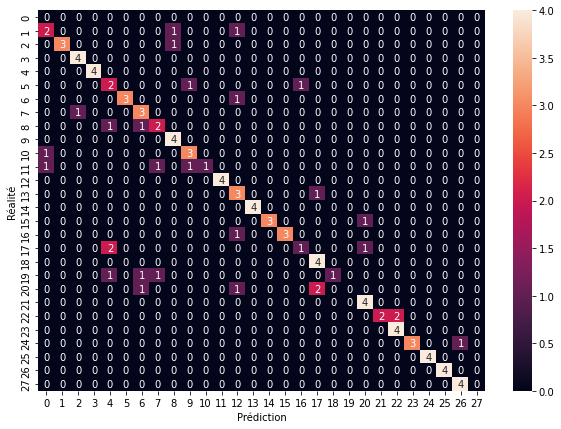

In [ ]:
# Stocker les prédictions de validation dans une variable
y_pred_valid = model.predict(X_test_tran)
# Transformer les prédictions en étiquettes
y_pred_valid_labels = [np.argmax(i) for i in y_pred_valid]
# Créer la matrice de confusion
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_valid_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
